Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


%matplotlib inline

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

Notes:
- dataset consists of continuous sensor data, recorded in 100 Hz frequency (upto 100 readings per second)
- each of the datasets consists of 10 set motions, resulting in a total of 30 sets of exercise data.

Helper Functions

In [3]:
def plot_xyz(time, x = None, y = None, z = None, plot_name = "", x_label = "", y_label = ""):
    if x is not None:
        plt.plot(time, x, label="x")
    if y is not None:
        plt.plot(time, y, label="y")
    if z is not None:
        plt.plot(time, z, label="z")

    plt.title(plot_name)

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.legend()
    
    # plt.show()

In [4]:
def find_magnitude_and_active(x,y,z, min_magnitude_threshold = 1, max_magnitude_threshold = 2):
    """calculate if movement is active from magnitute"""
    magnitude = np.sqrt(x**2 + y**2 + z**2)
    active = (magnitude > min_magnitude_threshold) and (magnitude < max_magnitude_threshold)

    return magnitude, active

In [5]:
def trim_data(data = None, begin = 0, end = 0):
    if not data.empty:
        total = data.shape[0]
        data = data.tail(-begin)
        data = data.head(total-end)

        return data

Squat data = 10 reps

In [6]:
squat_data = pd.read_csv("./rawdata/Squat_x10-Accelerometer.csv")

In [7]:
squat_data.head()

,time,seconds_elapsed,z,y,x
0,1697910552273722400,0.126722,0.298795,-0.050724,0.907530
1,1697910552292690000,0.145690,-0.102528,0.207921,0.244633
2,1697910552311657700,0.164658,-0.574512,0.063103,-0.183742
3,1697910552330625300,0.183625,1.251686,0.108361,0.168333
4,1697910552349593000,0.202593,-0.105359,0.113360,0.054346


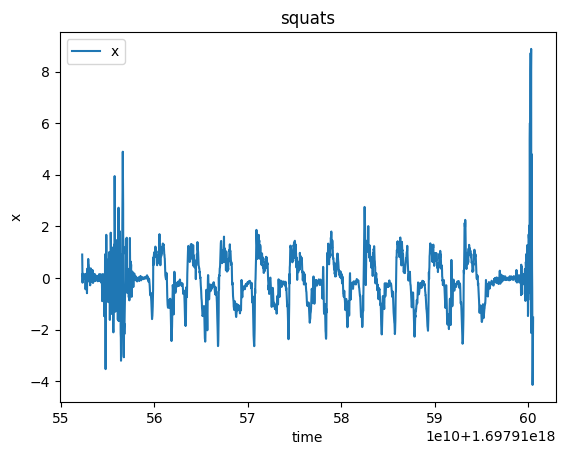

In [8]:
plot_xyz(time=squat_data.time, x=squat_data.x, plot_name="squats", x_label="time", y_label="x")
# plot_xyz(time=squat_data.time, y=squat_data.y, plot_name="squats", x_label="time", y_label="y")
# plot_xyz(time=squat_data.time, z=squat_data.z, plot_name="squats", x_label="time", y_label="z")

In [9]:
total = squat_data.x.count()
total

2545

In [10]:
tmp_df = pd.DataFrame(columns=["magnitude","active"])

for index, row in squat_data.iterrows():
    x = row.x
    y = row.y
    z = row.z
    
    tmp_df.loc[len(tmp_df)] = find_magnitude_and_active(x,y,z,min_magnitude_threshold=1, max_magnitude_threshold=2)

# tmp_df

# tmp_df.drop(tmp_df[tmp_df['active'] != True].index, inplace=True)

squat_data = pd.concat([squat_data, tmp_df], axis=1)

squat_data

,time,seconds_elapsed,z,y,x,magnitude,active
0,1697910552273722400,0.126722,0.298795,-0.050724,0.907530,0.956798,False
1,1697910552292690000,0.145690,-0.102528,0.207921,0.244633,0.337029,False
2,1697910552311657700,0.164658,-0.574512,0.063103,-0.183742,0.606471,False
3,1697910552330625300,0.183625,1.251686,0.108361,0.168333,1.267595,True
4,1697910552349593000,0.202593,-0.105359,0.113360,0.054346,0.164026,False
...,...,...,...,...,...,...,...
2540,1697910600452228600,48.305229,-4.518544,-6.295443,-2.293788,8.081541,False
2541,1697910600471197000,48.324197,-3.329393,-7.112526,-4.145200,8.880066,False
2542,1697910600490165200,48.343165,-1.305591,-6.103888,-3.567004,7.189265,False
2543,1697910600509133300,48.362133,0.376825,-5.045290,-2.581239,5.679766,False


In [11]:
squat_data.active.unique()

array([False,  True])

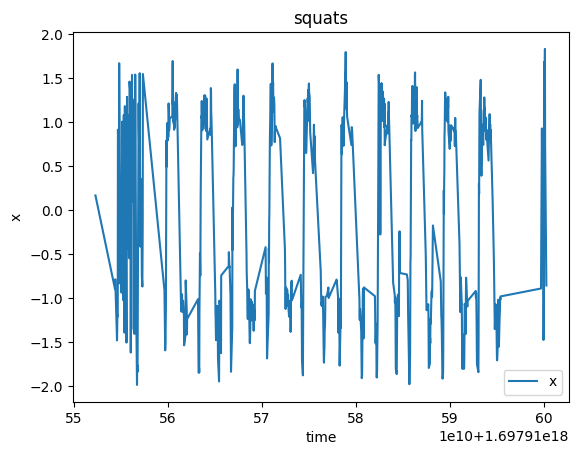

In [12]:
# tmp_df = squat_data.drop(squat_data[squat_data['active'] != True].index, inplace=False)

squat_data.drop(squat_data[squat_data['active'] != True].index, inplace=True)

plot_xyz(time=squat_data.time, x=squat_data.x, plot_name="squats", x_label="time", y_label="x")

764


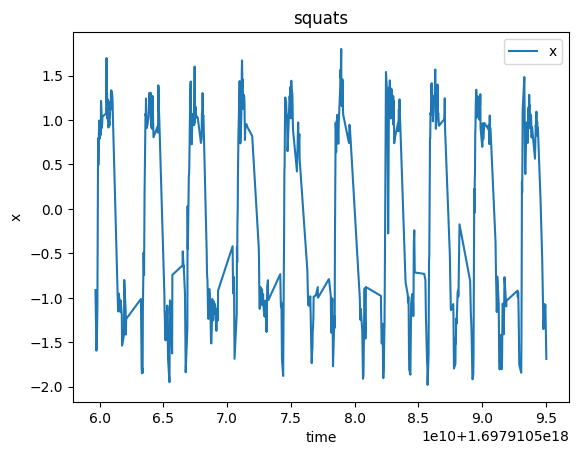

In [13]:
#trim data
squat_data = trim_data(squat_data, begin=65, end=100)
# squat_data = squat_data.tail(-400)
# squat_data = squat_data.head(total-600)

plot_xyz(time=squat_data.time, x=squat_data.x, plot_name="squats", x_label="time", y_label="x")
# plot_xyz(time=squat_data.time, y=squat_data.y, plot_name="squats", x_label="time", y_label="y")
# plot_xyz(time=squat_data.time, z=squat_data.z, plot_name="squats", x_label="time", y_label="z")

print(squat_data.x.count())

In [14]:
squat_data.describe()

,time,seconds_elapsed,z,y,x,magnitude
count,7.640000e+02,764.000000,764.000000,764.000000,764.000000,764.000000
mean,1.697911e+18,25.061788,0.014593,-0.016190,-0.133780,1.339416
std,1.065240e+10,10.652401,0.696394,0.248973,1.135992,0.243798
min,1.697911e+18,7.524126,-1.652231,-1.194305,-1.979692,1.000540
25%,1.697911e+18,15.941070,-0.571901,-0.177369,-1.152578,1.144672
50%,1.697911e+18,24.509795,0.192107,-0.014816,-0.511917,1.284457
75%,1.697911e+18,34.159745,0.567903,0.124406,1.018879,1.498895
max,1.697911e+18,42.880325,1.480054,1.656756,1.799653,1.999650


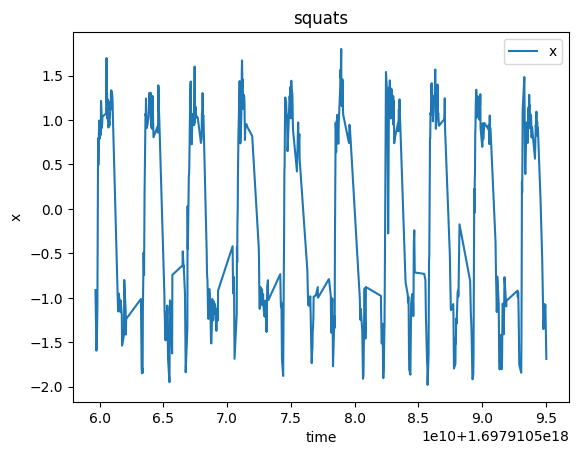

In [15]:
plot_xyz(time=squat_data.time, x=squat_data.x, plot_name="squats", x_label="time", y_label="x")
# plot_xyz(time=squat_data.time, y=squat_data.y, plot_name="squats", x_label="time", y_label="y")
# plot_xyz(time=squat_data.time, z=squat_data.z, plot_name="squats", x_label="time", y_label="z")

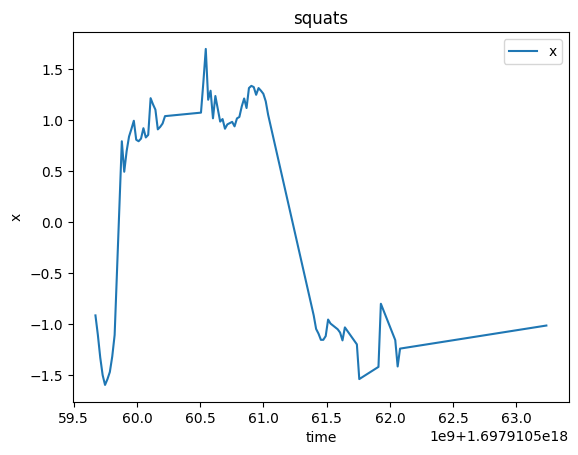

In [16]:
# select and plot just one rep
rep_pointcounts = 75
plot_xyz(time=squat_data.head(rep_pointcounts).time, x=squat_data.head(rep_pointcounts).x, plot_name="squats", x_label="time", y_label="x")

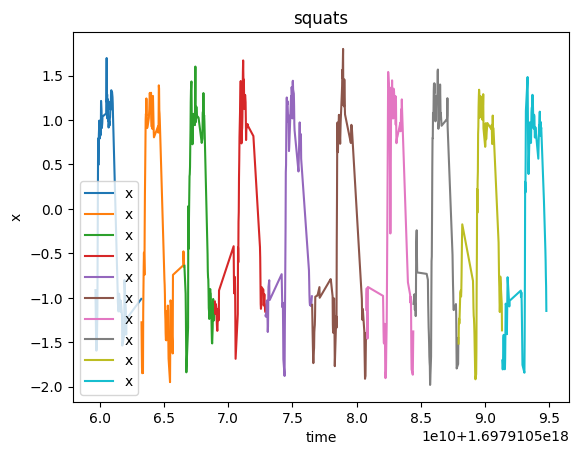

In [17]:
# visualize each rep
rep_pointcounts = 75
increment = 75
for i in range(0,10):
    plot_xyz(time=squat_data[rep_pointcounts-increment:rep_pointcounts].time, x=squat_data[rep_pointcounts-increment:rep_pointcounts].x, plot_name="squats", x_label="time", y_label="x")

    rep_pointcounts += increment

In [18]:
# TODO: ADD EACH REP IN ONE ROW OF DATA: time, x_1 y_1 z_1. x_2, y_2, z_2, etc

rep_pointcounts = 75
increment = 75

squat_data_rows = pd.DataFrame()

for i in range(0,10):
    #todo later in this cell: convert all the data in one_data_row DataFrame into one row
    tmp_df = squat_data[rep_pointcounts-increment:rep_pointcounts]
    # print(one_data_row)
    time_taken = max(tmp_df.seconds_elapsed) - min(tmp_df.seconds_elapsed) #time taken for one rep
    # print(time_taken)



    one_data_row = pd.DataFrame(tmp_df.magnitude.values.flatten()).transpose()
    one_data_row['time'] = [time_taken]
    one_data_row["label"] = ["squat"]

    squat_data_rows = pd.concat([squat_data_rows, one_data_row], ignore_index=True, sort=False)
    
    # break

    rep_pointcounts += increment



squat_data_rows.columns = squat_data_rows.columns.astype(str)



squat_data_rows

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,time,label
0,1.010013,1.175851,1.346741,1.534688,1.639805,1.577438,1.569638,1.444309,1.186997,1.172959,...,1.286869,1.712883,1.630071,1.073985,1.367191,1.754849,1.639097,1.173879,3.565935,squat
1,1.308733,1.568251,1.787315,1.851228,1.835027,1.821087,1.926575,1.452875,1.127672,1.016118,...,1.110556,1.225092,1.586482,1.927736,1.062672,1.146066,1.102189,1.063090,3.319360,squat
2,1.091372,1.072504,1.222190,1.531466,1.889641,1.575792,1.122392,1.257528,1.024202,1.196227,...,1.152808,1.013437,1.082895,1.088111,1.281209,1.249475,1.135269,1.065637,2.352007,squat
3,1.054961,1.096029,1.200273,1.178873,1.085870,1.095240,1.121030,1.205708,1.330518,1.471028,...,1.217610,1.184865,1.101593,1.041209,1.100048,1.083872,1.158308,1.167217,3.926341,squat
4,1.227754,1.224267,1.245967,1.243380,1.193508,1.188145,1.248281,1.354212,1.451679,1.604801,...,1.127239,1.122882,1.122474,1.085421,1.082876,1.059899,1.098461,1.012436,3.603896,squat
5,1.106525,1.246313,1.413925,1.548805,1.674563,1.754455,1.665414,1.618747,1.600268,1.462389,...,1.390714,1.613691,1.786524,1.945439,1.925829,1.914826,1.676938,1.501099,4.191911,squat
6,1.275056,1.109288,1.083160,1.327332,1.649876,1.939906,1.828392,1.254222,1.049917,1.268876,...,1.327104,1.266378,1.319001,1.629315,1.813582,1.935490,1.689272,1.466340,3.660819,squat
7,1.173110,1.104457,1.315074,1.311840,1.307200,1.210807,1.573240,1.632367,1.048056,1.672664,...,1.304893,1.216968,1.074892,1.191371,1.470428,1.798620,1.821199,1.547833,3.490116,squat
8,1.582613,1.359130,1.310214,1.369551,1.300151,1.193765,1.084815,1.017854,1.038047,1.156299,...,1.398391,1.362224,1.323874,1.337947,1.245838,1.002231,1.103522,1.385594,3.376317,squat
9,1.738917,1.771292,1.811922,1.763279,1.628302,1.490611,1.528385,1.742674,1.999650,1.981990,...,1.159133,1.108535,1.078630,1.156270,1.236254,1.258761,1.272014,1.461559,3.433231,squat


In [19]:
#save squat_data_rows
squat_data_rows.to_csv("./dataset/squat_data_rows.csv",index=False)

Lunge data = 10 reps

In [20]:
lunges_data = pd.read_csv("./rawdata/Lunges_x10-Accelerometer.csv")

In [21]:
lunges_data.head()

,time,seconds_elapsed,z,y,x
0,1697908570387722500,0.104722,0.978403,0.368146,0.777332
1,1697908570406693000,0.123693,0.805919,0.399575,0.837341
2,1697908570425664000,0.142664,0.820622,-0.035355,0.211082
3,1697908570444634600,0.161635,0.344588,-0.361883,-0.535677
4,1697908570463605200,0.180605,0.179651,-0.027220,-0.831452


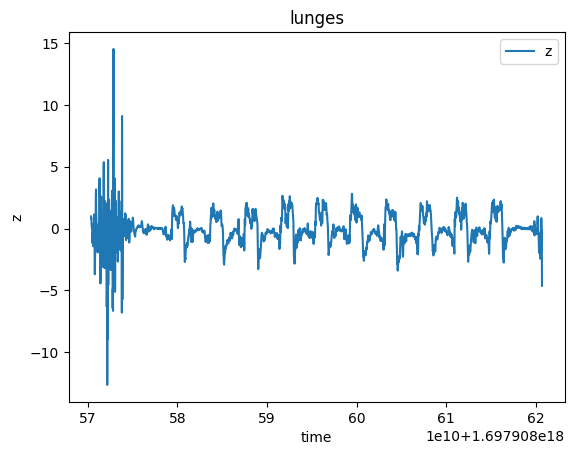

In [22]:
# plot_xyz(time=lunges_data.time, x=lunges_data.x, plot_name="lunges", x_label="time", y_label="x")
# plot_xyz(time=lunges_data.time, y=lunges_data.y, plot_name="lunges", x_label="time", y_label="y")
plot_xyz(time=lunges_data.time, z=lunges_data.z, plot_name="lunges", x_label="time", y_label="z")

In [23]:
total = lunges_data.x.count()
total

2651

In [24]:
tmp_df = pd.DataFrame(columns=["magnitude","active"])

for index, row in lunges_data.iterrows():
    x = row.x
    y = row.y
    z = row.z
    
    tmp_df.loc[len(tmp_df)] = find_magnitude_and_active(x,y,z,min_magnitude_threshold=1, max_magnitude_threshold=3)

# tmp_df

# tmp_df.drop(tmp_df[tmp_df['active'] != True].index, inplace=True)

lunges_data = pd.concat([lunges_data, tmp_df], axis=1)

lunges_data

,time,seconds_elapsed,z,y,x,magnitude,active
0,1697908570387722500,0.104722,0.978403,0.368146,0.777332,1.302709,True
1,1697908570406693000,0.123693,0.805919,0.399575,0.837341,1.228945,True
2,1697908570425664000,0.142664,0.820622,-0.035355,0.211082,0.848072,False
3,1697908570444634600,0.161635,0.344588,-0.361883,-0.535677,0.732564,False
4,1697908570463605200,0.180605,0.179651,-0.027220,-0.831452,0.851075,False
...,...,...,...,...,...,...,...
2646,1697908620584333600,50.301333,0.844411,-1.412029,5.993021,6.214753,False
2647,1697908620603304200,50.320304,-0.259397,0.255169,9.896754,9.903441,False
2648,1697908620622275000,50.339275,-0.156051,-1.340017,5.191344,5.363772,False
2649,1697908620641246000,50.358246,-0.737049,-0.287605,3.316982,3.410034,False


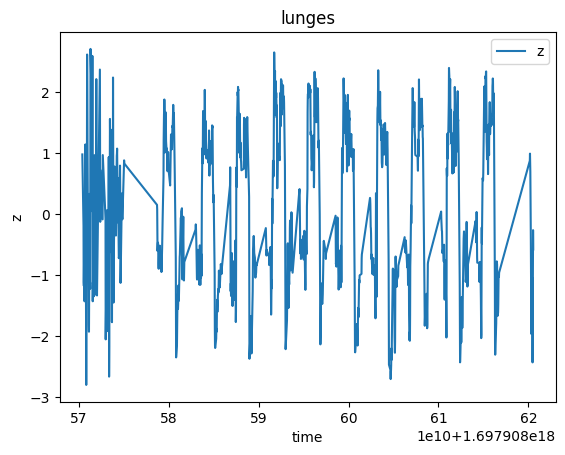

In [25]:
lunges_data.drop(lunges_data[lunges_data['active'] != True].index, inplace=True)

plot_xyz(time=lunges_data.time, z=lunges_data.z, plot_name="lunges", x_label="time", y_label="z")

1185


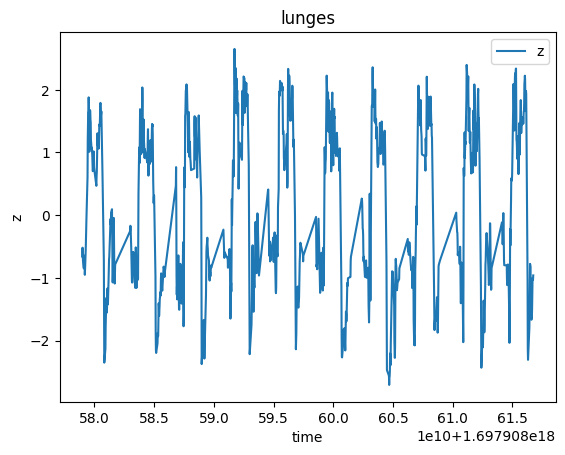

In [26]:
#trim data

lunges_data = trim_data(lunges_data, begin=130, end=147)

# plot_xyz(time=lunges_data.time, x=lunges_data.x, plot_name="lunges", x_label="time", y_label="x")
# plot_xyz(time=lunges_data.time, y=lunges_data.y, plot_name="lunegs", x_label="time", y_label="y")
plot_xyz(time=lunges_data.time, z=lunges_data.z, plot_name="lunges", x_label="time", y_label="z")

print(lunges_data.x.count())

In [27]:
lunges_data.describe()

,time,seconds_elapsed,z,y,x,magnitude
count,1.185000e+03,1185.000000,1185.000000,1185.000000,1185.000000,1185.000000
mean,1.697909e+18,27.585745,0.190227,-0.009343,0.019865,1.763628
std,1.115089e+10,11.150889,1.305693,0.593108,1.133554,0.515018
min,1.697909e+18,8.698471,-2.707149,-2.070369,-2.840166,1.000832
25%,1.697909e+18,17.633681,-0.950722,-0.394141,-0.901421,1.327735
50%,1.697909e+18,28.314197,0.343013,0.009068,0.084591,1.673808
75%,1.697909e+18,36.964857,1.359149,0.378422,0.990668,2.138890
max,1.697909e+18,46.469225,2.651974,2.010759,2.352777,2.999684


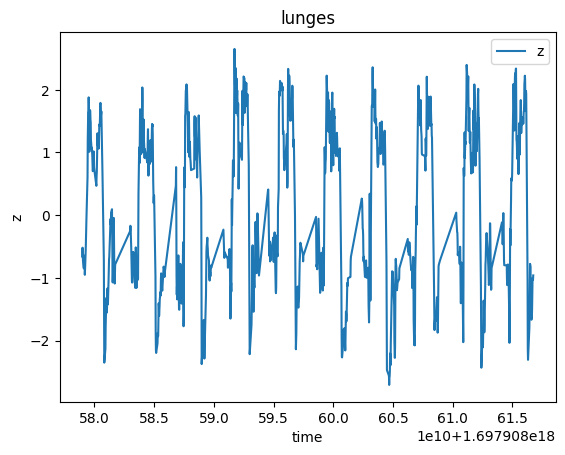

In [28]:
# plot_xyz(time=lunges_data.time, x=lunges_data.x, plot_name="lunges", x_label="time", y_label="x")
# plot_xyz(time=lunges_data.time, y=lunges_data.y, plot_name="lunegs", x_label="time", y_label="y")
plot_xyz(time=lunges_data.time, z=lunges_data.z, plot_name="lunges", x_label="time", y_label="z")

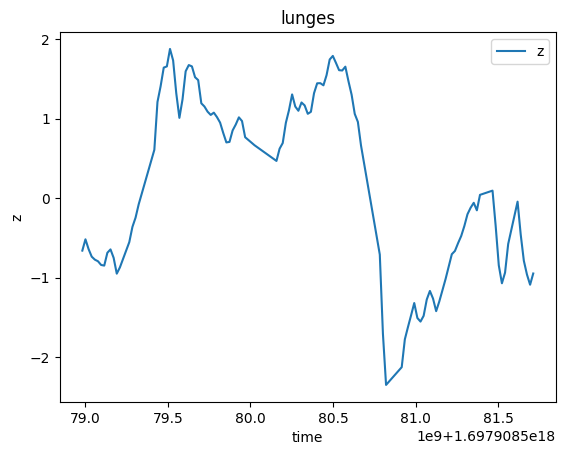

In [29]:
# select and plot just one rep
rep_pointcounts = 116
plot_xyz(time=lunges_data.head(rep_pointcounts).time, z=lunges_data.head(rep_pointcounts).z, plot_name="lunges", x_label="time", y_label="z")

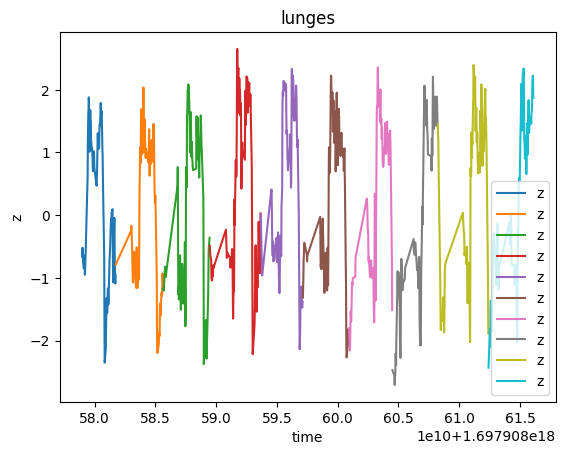

In [30]:
# visualize each rep
rep_pointcounts = 116
increment = 116
for i in range(0,10):
    plot_xyz(time=lunges_data[rep_pointcounts-increment:rep_pointcounts].time,
             z=lunges_data[rep_pointcounts-increment:rep_pointcounts].z,
             plot_name="lunges", x_label="time", y_label="z")

    rep_pointcounts += increment

In [31]:
# TODO: ADD EACH REP IN ONE ROW OF DATA: time, x_1 y_1 z_1. x_2, y_2, z_2, etc

rep_pointcounts = 116
increment = 116

lunge_data_rows = pd.DataFrame()

for i in range(0,10):
    #todo later in this cell: convert all the data in one_data_row DataFrame into one row
    tmp_df = lunges_data[rep_pointcounts-increment:rep_pointcounts]
    
    # print(one_data_row)
    time_taken = max(tmp_df.seconds_elapsed) - min(tmp_df.seconds_elapsed) #time taken for one rep
    # print(time_taken)



    one_data_row = pd.DataFrame(tmp_df.magnitude.values.flatten()).transpose()
    one_data_row['time'] = [time_taken]
    one_data_row["label"] = ["lunge"]

    lunge_data_rows = pd.concat([lunge_data_rows, one_data_row], ignore_index=True, sort=False)
    
    # break

    rep_pointcounts += increment



lunge_data_rows.columns = lunge_data_rows.columns.astype(str)



lunge_data_rows

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,time,label
0,1.321541,1.397051,1.521869,1.497659,1.457437,1.435091,1.451893,1.412105,1.316587,1.152222,...,1.532090,1.550830,1.231050,1.302923,1.284467,1.624613,1.830032,1.596631,2.731785,lunge
1,1.094051,1.009086,1.221358,1.151511,1.166151,1.175270,1.199655,1.585773,1.869091,1.660936,...,1.797803,1.539843,1.284763,1.096780,1.157160,1.291274,1.207724,1.255927,3.907969,lunge
2,1.326648,1.394885,1.335913,1.222032,1.080076,1.018759,1.020792,1.101279,1.005539,1.486455,...,2.213117,2.693137,2.386683,1.593771,1.147325,1.417243,1.319817,1.100216,3.794143,lunge
3,1.449677,1.556459,1.309642,1.081125,1.163228,1.164426,1.282678,1.297393,1.110904,1.012025,...,1.518332,1.158978,1.230721,1.853992,1.849995,1.295049,1.522156,1.077832,4.173558,lunge
4,1.385404,1.080067,1.069076,1.321821,1.691831,1.770395,1.500162,1.260606,1.693501,1.972848,...,2.324374,1.814062,1.287914,1.409054,1.514467,1.624178,1.754932,2.038855,3.452672,lunge
5,2.378469,2.504113,2.422870,2.193754,1.872858,1.454070,1.058025,1.342240,1.349545,1.014274,...,1.655889,2.213907,2.494398,2.967957,2.968667,2.340539,2.033237,2.058226,3.775176,lunge
6,2.552210,2.852633,2.518493,2.162424,1.848650,1.615451,1.639302,1.807529,1.837241,1.736107,...,1.294100,1.410456,1.436671,1.501886,1.372421,1.183997,1.049313,1.763616,3.547529,lunge
7,2.698096,2.852545,2.702316,2.737156,2.600597,2.633287,2.555702,2.237953,2.446984,2.828826,...,1.672956,1.483969,1.577077,1.888111,1.915429,1.867486,1.674560,1.511152,3.718270,lunge
8,1.529058,1.359246,1.347198,1.288412,1.227141,1.298998,1.855901,2.294355,2.571990,2.991903,...,1.703093,1.640266,1.687068,1.445311,1.259915,1.142841,1.548039,2.262310,4.154601,lunge
9,2.858865,2.993066,2.643013,2.359256,1.932255,1.493663,1.430133,1.664577,1.924492,2.005734,...,1.843890,1.772277,1.794320,2.130048,2.234890,2.376036,2.371938,2.042991,3.680336,lunge


In [32]:
#save lunge_data_rows
lunge_data_rows.to_csv("./dataset/lunge_data_rows.csv",index=False)

Jumping Jacks data = 10 reps

In [33]:
jumpingjacks_data = pd.read_csv("./rawdata/Jumping_Jack_x10-Accelerometer.csv")

In [34]:
jumpingjacks_data.head()

,time,seconds_elapsed,z,y,x
0,1697907772923994400,0.096994,0.000000,0.000000,0.000000
1,1697907772942964700,0.115965,-0.264719,-0.080521,0.509150
2,1697907772961935000,0.134935,-0.644283,-0.267902,-0.396041
3,1697907772980905500,0.153906,-1.593638,0.126882,-0.053316
4,1697907772999875800,0.172876,-1.619778,0.346205,-0.090494


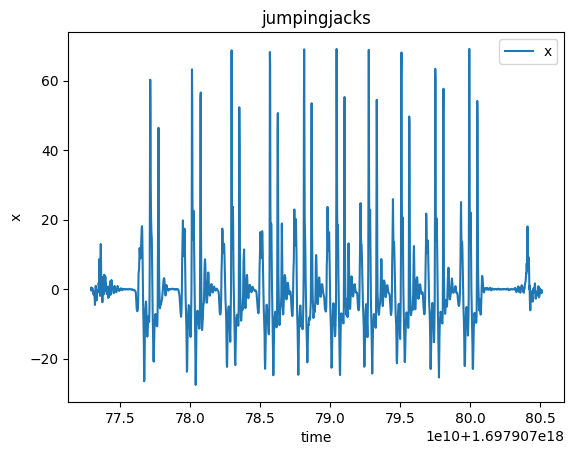

In [35]:
plot_xyz(time=jumpingjacks_data.time, x=jumpingjacks_data.x, plot_name="jumpingjacks", x_label="time", y_label="x")
# plot_xyz(time=jumpingjacks_data.time, y=jumpingjacks_data.y, plot_name="jumpingjacks", x_label="time", y_label="y")
# plot_xyz(time=jumpingjacks_data.time, z=jumpingjacks_data.z, plot_name="jumpingjacks", x_label="time", y_label="z")

In [36]:
total = jumpingjacks_data.x.count()
total

1697

In [37]:
tmp_df = pd.DataFrame(columns=["magnitude","active"])

for index, row in jumpingjacks_data.iterrows():
    x = row.x
    y = row.y
    z = row.z
    
    tmp_df.loc[len(tmp_df)] = find_magnitude_and_active(x,y,z,min_magnitude_threshold=1, max_magnitude_threshold=70)

# tmp_df

# tmp_df.drop(tmp_df[tmp_df['active'] != True].index, inplace=True)

jumpingjacks_data = pd.concat([jumpingjacks_data, tmp_df], axis=1)

jumpingjacks_data

,time,seconds_elapsed,z,y,x,magnitude,active
0,1697907772923994400,0.096994,0.000000,0.000000,0.000000,0.000000,False
1,1697907772942964700,0.115965,-0.264719,-0.080521,0.509150,0.579477,False
2,1697907772961935000,0.134935,-0.644283,-0.267902,-0.396041,0.802323,False
3,1697907772980905500,0.153906,-1.593638,0.126882,-0.053316,1.599570,True
4,1697907772999875800,0.172876,-1.619778,0.346205,-0.090494,1.658833,True
...,...,...,...,...,...,...,...
1692,1697907805021821200,32.194821,-1.854222,0.289712,-1.180064,2.216895,True
1693,1697907805040791600,32.213792,-0.709826,-0.156613,-0.946898,1.193733,True
1694,1697907805059762000,32.232762,-0.178381,-0.262516,-0.686109,0.755963,False
1695,1697907805078732300,32.251732,0.191574,0.057424,-0.211668,0.291207,False


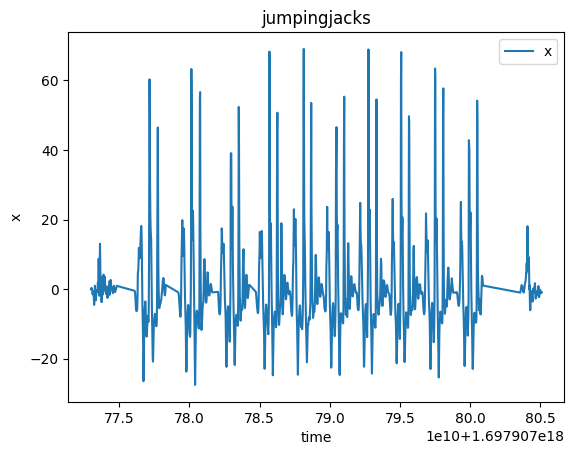

In [38]:
jumpingjacks_data.drop(jumpingjacks_data[jumpingjacks_data['active'] != True].index, inplace=True)

plot_xyz(time=jumpingjacks_data.time, x=jumpingjacks_data.x, plot_name="jumpingjacks", x_label="time", y_label="x")

1147


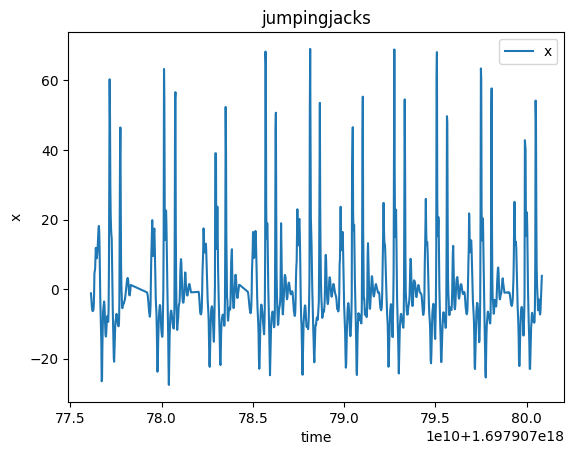

In [39]:
#trim data

jumpingjacks_data = trim_data(jumpingjacks_data, begin=90, end=165)

plot_xyz(time=jumpingjacks_data.time, x=jumpingjacks_data.x, plot_name="jumpingjacks", x_label="time", y_label="x")
# plot_xyz(time=jumpingjacks_data.time, y=jumpingjacks_data.y, plot_name="jumpingjacks", x_label="time", y_label="y")
# plot_xyz(time=jumpingjacks_data.time, z=jumpingjacks_data.z, plot_name="jumpingjacks", x_label="time", y_label="z")

print(jumpingjacks_data.x.count())

In [40]:
jumpingjacks_data.describe()

,time,seconds_elapsed,z,y,x,magnitude
count,1.147000e+03,1147.000000,1147.000000,1147.000000,1147.000000,1147.000000
mean,1.697908e+18,16.098129,0.571158,-0.003538,-0.108553,10.373412
std,7.058140e+09,7.058140,2.812874,1.625381,14.133263,10.145935
min,1.697908e+18,3.302986,-11.686410,-12.125035,-27.526722,1.013961
25%,1.697908e+18,10.274590,-0.890018,-0.494405,-7.772814,4.431143
50%,1.697908e+18,16.278703,0.391467,0.094328,-3.638919,7.689435
75%,1.697908e+18,22.150023,2.033152,0.622553,4.049367,12.734363
max,1.697908e+18,28.002374,13.234056,8.594841,69.023575,69.382046


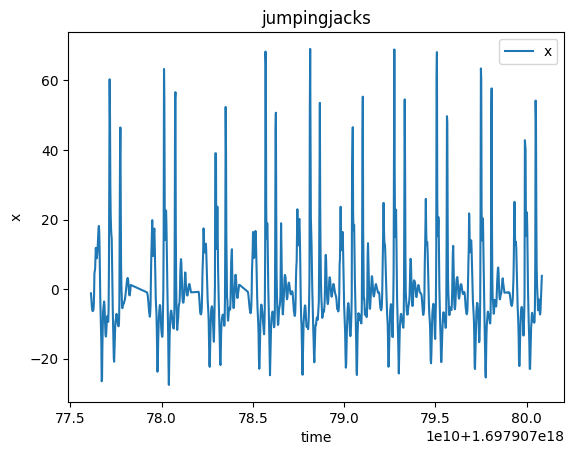

In [41]:
plot_xyz(time=jumpingjacks_data.time, x=jumpingjacks_data.x, plot_name="jumpingjacks", x_label="time", y_label="x")
# plot_xyz(time=jumpingjacks_data.time, y=jumpingjacks_data.y, plot_name="jumpingjacks", x_label="time", y_label="y")
# plot_xyz(time=jumpingjacks_data.time, z=jumpingjacks_data.z, plot_name="jumpingjacks", x_label="time", y_label="z")

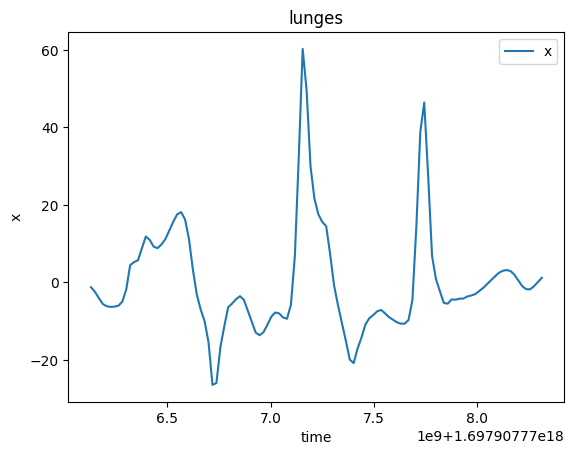

In [42]:
# select and plot just one rep
rep_pointcounts = 114
plot_xyz(time=jumpingjacks_data.head(rep_pointcounts).time, x=jumpingjacks_data.head(rep_pointcounts).x, plot_name="lunges", x_label="time", y_label="x")

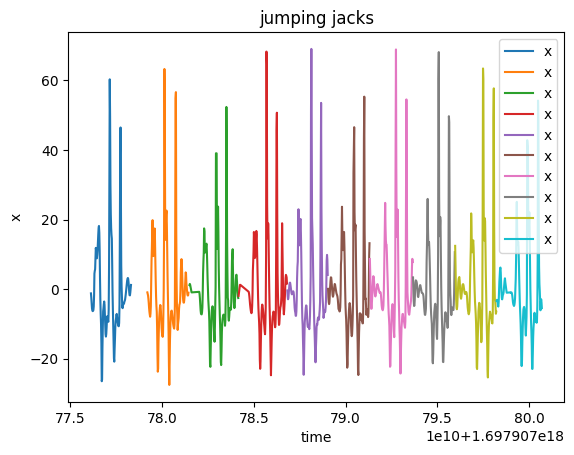

In [43]:
# visualize each rep
rep_pointcounts = 114
increment = 114
for i in range(0,10):
    plot_xyz(time=jumpingjacks_data[rep_pointcounts-increment:rep_pointcounts].time, x=jumpingjacks_data[rep_pointcounts-increment:rep_pointcounts].x, plot_name="jumping jacks", x_label="time", y_label="x")

    rep_pointcounts += increment

In [44]:
# TODO: ADD EACH REP IN ONE ROW OF DATA: time, x_1 y_1 z_1. x_2, y_2, z_2, etc

rep_pointcounts = 114
increment = 114

jumpingjack_data_rows = pd.DataFrame()

for i in range(0,10):
    #todo later in this cell: convert all the data in one_data_row DataFrame into one row
    tmp_df = jumpingjacks_data[rep_pointcounts-increment:rep_pointcounts]

    # print(one_data_row)
    
    time_taken = max(tmp_df.seconds_elapsed) - min(tmp_df.seconds_elapsed) #time taken for one rep
    # print(time_taken)



    one_data_row = pd.DataFrame(tmp_df.magnitude.values.flatten()).transpose()
    one_data_row['time'] = [time_taken]
    one_data_row["label"] = ["jumpingjack"]

    jumpingjack_data_rows = pd.concat([jumpingjack_data_rows, one_data_row], ignore_index=True, sort=False)
    
    # break

    rep_pointcounts += increment



jumpingjack_data_rows.columns = jumpingjack_data_rows.columns.astype(str)



jumpingjack_data_rows

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,time,label
0,1.771690,2.783547,4.126683,5.562920,6.485395,7.278097,7.507323,7.089299,5.433110,2.450920,...,3.277445,3.183886,2.350924,1.044377,1.868519,1.894015,1.013961,1.261506,2.181591,jumpingjack
1,1.292637,1.895576,2.433832,3.164748,4.218052,5.499896,6.634956,7.662248,8.192541,7.087786,...,2.431924,4.822401,4.680457,1.877820,1.639027,1.910718,1.819215,1.106402,2.238501,jumpingjack
2,1.165809,1.505434,1.253082,1.119761,1.041567,1.821282,3.217742,4.904669,6.408543,7.109666,...,2.792470,4.077459,4.266979,2.903763,1.060042,1.056010,2.227342,2.654173,2.655848,jumpingjack
3,2.087778,1.269255,1.255058,1.021733,1.606929,2.619780,3.700268,4.575280,5.333784,6.181123,...,4.214843,2.229457,1.482693,3.388199,4.110791,3.959585,3.442687,1.691923,2.636878,jumpingjack
4,1.084450,2.399457,3.068594,2.725794,1.396699,1.296058,1.938170,2.011552,1.336840,1.174946,...,7.407855,5.766902,3.650672,1.550317,8.609656,10.005177,8.493504,4.309285,2.200559,jumpingjack
5,1.386335,2.753915,3.967781,4.357675,3.781089,2.114253,1.511151,2.322669,3.412793,3.518817,...,6.119318,6.774788,7.876344,8.767505,7.285544,1.812391,10.119131,14.320967,2.257470,jumpingjack
6,8.731652,5.124143,3.867618,5.673063,5.605822,3.726659,2.260738,1.896639,2.868107,3.831176,...,5.610252,5.103957,4.015474,2.074745,1.775398,6.970128,8.840253,7.781355,2.333352,jumpingjack
7,3.380285,3.403353,4.906790,4.781866,3.077541,1.615837,2.441585,2.595171,2.480422,2.206368,...,5.861791,6.196473,6.579399,6.260490,4.639249,1.508874,5.689355,11.168394,2.276441,jumpingjack
8,12.456061,7.157142,1.390223,3.176752,5.324004,5.787550,4.905177,2.694700,1.600603,2.215328,...,58.677293,18.989101,4.235933,5.970551,4.395808,6.664345,7.836383,7.060599,2.238500,jumpingjack
9,3.943436,3.935164,5.294358,5.449698,5.276270,5.183024,3.704006,1.970899,3.099322,4.128206,...,2.592694,2.847275,4.489004,6.442136,5.009802,3.326984,4.264951,5.864118,2.466145,jumpingjack


In [45]:
#save jumpingjack_data_rows
jumpingjack_data_rows.to_csv("./dataset/jumpingjack_data_rows.csv", index=False)

Put all data together:  
squat_data_rows, 
jumpingjack_data_rows, 
lunge_data_rows

In [46]:
df1 = pd.read_csv("./dataset/squat_data_rows.csv")
df2 = pd.read_csv("./dataset/lunge_data_rows.csv")
df3 = pd.read_csv("./dataset/jumpingjack_data_rows.csv")

In [47]:
print("Shape of squat dataset", df1.shape)
print("Shape of lunge dataset", df2.shape)
print("Shape of jumpingjack dataset", df3.shape)

Shape of squat dataset (10, 77)
Shape of lunge dataset (10, 118)
Shape of jumpingjack dataset (10, 116)


In [48]:
max_width = max( [df1.shape[1],df2.shape[1],df3.shape[1]] )
print(max_width)
# max_width - df1.shape[1]
# max_width - df2.shape[1]
# max_width - df3.shape[1]

118


In [49]:
df1

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,time,label
0,1.010013,1.175851,1.346741,1.534688,1.639805,1.577438,1.569638,1.444309,1.186997,1.172959,...,1.286869,1.712883,1.630071,1.073985,1.367191,1.754849,1.639097,1.173879,3.565935,squat
1,1.308733,1.568251,1.787315,1.851228,1.835027,1.821087,1.926575,1.452875,1.127672,1.016118,...,1.110556,1.225092,1.586482,1.927736,1.062672,1.146066,1.102189,1.063090,3.319360,squat
2,1.091372,1.072504,1.222190,1.531466,1.889641,1.575792,1.122392,1.257528,1.024202,1.196227,...,1.152808,1.013437,1.082895,1.088111,1.281209,1.249475,1.135269,1.065637,2.352007,squat
3,1.054961,1.096029,1.200273,1.178873,1.085870,1.095240,1.121030,1.205708,1.330518,1.471028,...,1.217610,1.184865,1.101593,1.041209,1.100048,1.083872,1.158308,1.167217,3.926341,squat
4,1.227754,1.224267,1.245967,1.243380,1.193508,1.188145,1.248281,1.354212,1.451679,1.604801,...,1.127239,1.122882,1.122474,1.085421,1.082876,1.059899,1.098461,1.012436,3.603896,squat
5,1.106525,1.246313,1.413925,1.548805,1.674563,1.754455,1.665414,1.618747,1.600268,1.462389,...,1.390714,1.613691,1.786524,1.945439,1.925829,1.914826,1.676938,1.501099,4.191911,squat
6,1.275056,1.109288,1.083160,1.327332,1.649876,1.939906,1.828392,1.254222,1.049917,1.268876,...,1.327104,1.266378,1.319001,1.629315,1.813582,1.935490,1.689272,1.466340,3.660819,squat
7,1.173110,1.104457,1.315074,1.311840,1.307200,1.210807,1.573240,1.632367,1.048056,1.672664,...,1.304893,1.216968,1.074892,1.191371,1.470428,1.798620,1.821199,1.547833,3.490116,squat
8,1.582613,1.359130,1.310214,1.369551,1.300151,1.193765,1.084815,1.017854,1.038047,1.156299,...,1.398391,1.362224,1.323874,1.337947,1.245838,1.002231,1.103522,1.385594,3.376317,squat
9,1.738917,1.771292,1.811922,1.763279,1.628302,1.490611,1.528385,1.742674,1.999650,1.981990,...,1.159133,1.108535,1.078630,1.156270,1.236254,1.258761,1.272014,1.461559,3.433231,squat


In [50]:
df1 = pd.DataFrame( np.pad(df1, ((0,0),(max_width - df1.shape[1],0)), 'constant') )
df2 = pd.DataFrame( np.pad(df2, ((0,0),(max_width - df2.shape[1],0)), 'constant') )
df3 = pd.DataFrame( np.pad(df3, ((0,0),(max_width - df3.shape[1],0)), 'constant') )

In [51]:
final_df = pd.concat([df1,df2,df3], ignore_index=True)

In [52]:
final_df.columns = final_df.columns.astype(str)
column_list = final_df.columns.to_list()
column_list[-1] = 'label'
column_list[-2] = 'time'
final_df.columns = column_list

In [53]:
final_df

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,time,label
0,0,0,0,0,0,0,0,0,0,0,...,1.286869,1.712883,1.630071,1.073985,1.367191,1.754849,1.639097,1.173879,3.565935,squat
1,0,0,0,0,0,0,0,0,0,0,...,1.110556,1.225092,1.586482,1.927736,1.062672,1.146066,1.102189,1.06309,3.31936,squat
2,0,0,0,0,0,0,0,0,0,0,...,1.152808,1.013437,1.082895,1.088111,1.281209,1.249475,1.135269,1.065637,2.352007,squat
3,0,0,0,0,0,0,0,0,0,0,...,1.21761,1.184865,1.101593,1.041209,1.100048,1.083872,1.158308,1.167217,3.926341,squat
4,0,0,0,0,0,0,0,0,0,0,...,1.127239,1.122882,1.122474,1.085421,1.082876,1.059899,1.098461,1.012436,3.603896,squat
5,0,0,0,0,0,0,0,0,0,0,...,1.390714,1.613691,1.786524,1.945439,1.925829,1.914826,1.676938,1.501099,4.191911,squat
6,0,0,0,0,0,0,0,0,0,0,...,1.327104,1.266378,1.319001,1.629315,1.813582,1.93549,1.689272,1.46634,3.660819,squat
7,0,0,0,0,0,0,0,0,0,0,...,1.304893,1.216968,1.074892,1.191371,1.470428,1.79862,1.821199,1.547833,3.490116,squat
8,0,0,0,0,0,0,0,0,0,0,...,1.398391,1.362224,1.323874,1.337947,1.245838,1.002231,1.103522,1.385594,3.376317,squat
9,0,0,0,0,0,0,0,0,0,0,...,1.159133,1.108535,1.07863,1.15627,1.236254,1.258761,1.272014,1.461559,3.433231,squat


In [54]:
print("Shape of squat dataset", df1.shape)
print("Shape of lunge dataset", df2.shape)
print("Shape of jumpingjack dataset", df3.shape)

Shape of squat dataset (10, 118)
Shape of lunge dataset (10, 118)
Shape of jumpingjack dataset (10, 118)


In [55]:
final_df.to_csv("./dataset/final_dataset", index=False)

Classification

In [56]:
#load dataset
dataset = pd.read_csv("./dataset/final_dataset")
dataset

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,time,label
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.286869,1.712883,1.630071,1.073985,1.367191,1.754849,1.639097,1.173879,3.565935,squat
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.110556,1.225092,1.586482,1.927736,1.062672,1.146066,1.102189,1.063090,3.319360,squat
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.152808,1.013437,1.082895,1.088111,1.281209,1.249475,1.135269,1.065637,2.352007,squat
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.217610,1.184865,1.101593,1.041209,1.100048,1.083872,1.158308,1.167217,3.926341,squat
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.127239,1.122882,1.122474,1.085421,1.082876,1.059899,1.098461,1.012436,3.603896,squat
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.390714,1.613691,1.786524,1.945439,1.925829,1.914826,1.676938,1.501099,4.191911,squat
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.327104,1.266378,1.319001,1.629315,1.813582,1.935490,1.689272,1.466340,3.660819,squat
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.304893,1.216968,1.074892,1.191371,1.470428,1.798620,1.821199,1.547833,3.490116,squat
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.398391,1.362224,1.323874,1.337947,1.245838,1.002231,1.103522,1.385594,3.376317,squat
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.159133,1.108535,1.078630,1.156270,1.236254,1.258761,1.272014,1.461559,3.433231,squat


In [57]:
# encode label from strings to integers

label_encoder = LabelEncoder()

dataset["label"] = label_encoder.fit_transform(dataset.label)

dataset

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,time,label
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.286869,1.712883,1.630071,1.073985,1.367191,1.754849,1.639097,1.173879,3.565935,2
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.110556,1.225092,1.586482,1.927736,1.062672,1.146066,1.102189,1.063090,3.319360,2
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.152808,1.013437,1.082895,1.088111,1.281209,1.249475,1.135269,1.065637,2.352007,2
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.217610,1.184865,1.101593,1.041209,1.100048,1.083872,1.158308,1.167217,3.926341,2
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.127239,1.122882,1.122474,1.085421,1.082876,1.059899,1.098461,1.012436,3.603896,2
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.390714,1.613691,1.786524,1.945439,1.925829,1.914826,1.676938,1.501099,4.191911,2
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.327104,1.266378,1.319001,1.629315,1.813582,1.935490,1.689272,1.466340,3.660819,2
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.304893,1.216968,1.074892,1.191371,1.470428,1.798620,1.821199,1.547833,3.490116,2
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.398391,1.362224,1.323874,1.337947,1.245838,1.002231,1.103522,1.385594,3.376317,2
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.159133,1.108535,1.078630,1.156270,1.236254,1.258761,1.272014,1.461559,3.433231,2


-- LabelEncoded: Squat=2, Lunges=1, JumpingJacks=1

Train-Test Split

In [58]:
# dataset.drop(columns=["label"], axis=1)

In [59]:
train, test = train_test_split(dataset, test_size = 0.20, random_state=32, stratify=dataset.label) 

In [60]:
X_test = train.drop(columns=["label"], axis=1)
y_test = train["label"]

X_train = test.drop(columns=["label"], axis=1)
y_train = test["label"]

In [61]:
y_test.value_counts()

label
2    8
0    8
1    8
Name: count, dtype: int64

In [62]:
y_train.value_counts()

label
2    2
0    2
1    2
Name: count, dtype: int64

Scikit-Learn Code

SVM

In [63]:
svc = LinearSVC()

svc.fit(X_train, y_train) 

y_pred = svc.predict(X_test)

print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

ACCURACY OF THE MODEL:  0.6666666666666666
Confusion Matrix:
 [[0 5 3]
 [0 8 0]
 [0 0 8]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.62      1.00      0.76         8
           2       0.73      1.00      0.84         8

    accuracy                           0.67        24
   macro avg       0.45      0.67      0.53        24
weighted avg       0.45      0.67      0.53        24



c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\AppData\Local\Programs\Python\Pyth

Random Forest

In [64]:
rf = RandomForestClassifier(max_depth=1)

rf.fit(X_train, y_train) 

y_pred = rf.predict(X_test)

print("Test Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

Test Accuracy:  1.0
Confusion Matrix:
 [[8 0 0]
 [0 8 0]
 [0 0 8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



Pytorch Code

In [65]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [66]:
#convert to tensor

# X_train_tensor = torch.from_numpy(X_train.to_numpy())
# y_train_tensor = torch.from_numpy(y_train.to_numpy())

# X_test_tensor = torch.from_numpy(X_test.to_numpy())
# y_test_tensor = torch.from_numpy(y_test.to_numpy())

X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long).to(device)

#create tensor dataset for pytorch

train_tensor_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_tensor_dataset = TensorDataset(X_test_tensor, y_test_tensor)

#create dataloader

batch_size = 30
train_dataloader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)

In [67]:
input_size = X_train.shape[1]        #number of columnns/features
output_size = len(y_train.unique())  #number of classes

CNN1D

In [68]:
# Define a flexible Conv1D model
class Conv1DModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=hidden_size, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(hidden_size * (input_size // 2**3), output_size)
        # self.fc2 = nn.Linear(output_size, output_size)
        self.fc2 = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for Conv1D
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Instantiate the model with desired sizes
input_size = X_train.shape[1]
hidden_size = 64  # You can adjust this
output_size = len(label_encoder.classes_)
model = Conv1DModel(input_size, hidden_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_samples += labels.size(0)
    
    # Calculate and print average loss and accuracy for the epoch
    average_loss = total_loss / len(train_dataloader)
    accuracy = correct_predictions / total_samples
    print(f"Epoch {epoch + 1}/{num_epochs} | Loss: {average_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    

# Evaluation
model.eval()
all_preds = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.tolist())

# Convert predictions back to original labels
predicted_labels = label_encoder.inverse_transform(all_preds)

# Calculate accuracy
accuracy = accuracy_score(y_test, all_preds)
print(f" Test Accuracy: {accuracy * 100:.2f}%")

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Create classification report
class_report = classification_report(y_test, all_preds, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)

Epoch 1/10 | Loss: 1.0399 | Accuracy: 66.67%
Epoch 2/10 | Loss: 0.9328 | Accuracy: 33.33%
Epoch 3/10 | Loss: 0.9303 | Accuracy: 33.33%
Epoch 4/10 | Loss: 0.9269 | Accuracy: 33.33%
Epoch 5/10 | Loss: 0.9199 | Accuracy: 33.33%
Epoch 6/10 | Loss: 0.9101 | Accuracy: 33.33%
Epoch 7/10 | Loss: 0.8980 | Accuracy: 83.33%
Epoch 8/10 | Loss: 0.8849 | Accuracy: 100.00%
Epoch 9/10 | Loss: 0.8726 | Accuracy: 100.00%
Epoch 10/10 | Loss: 0.8598 | Accuracy: 100.00%
 Test Accuracy: 75.00%
Confusion Matrix:
[[2 6 0]
 [0 8 0]
 [0 0 8]]
Classification Report:
              precision    recall  f1-score   support

 jumpingjack       1.00      0.25      0.40         8
       lunge       0.57      1.00      0.73         8
       squat       1.00      1.00      1.00         8

    accuracy                           0.75        24
   macro avg       0.86      0.75      0.71        24
weighted avg       0.86      0.75      0.71        24



GRU

In [69]:
# Define a GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=5, batch_first=True)
        # self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out, h_n = self.gru(x)
        x = h_n[-1, :, :]  # Take the hidden state from the last time step
        # x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Instantiate the model with desired sizes and move to GPU
input_size = X_train.shape[1]
hidden_size = 128  # You can adjust this
output_size = len(label_encoder.classes_)
model = GRUModel(input_size, hidden_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        
        # Assuming each row is considered a sequence (sequence length = 1)
        inputs = inputs.unsqueeze(1)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_samples += labels.size(0)

    # Calculate and print average loss and accuracy for the epoch
    average_loss = total_loss / len(train_dataloader)
    accuracy = correct_predictions / total_samples
    print(f"Epoch {epoch + 1}/{num_epochs} | Loss: {average_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")

# Evaluation
model.eval()
all_preds = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        # Assuming each row is considered a sequence (sequence length = 1)
        inputs = inputs.unsqueeze(1)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.tolist())
        true_labels.extend(labels.tolist())

# Convert predictions back to original labels
predicted_labels = label_encoder.inverse_transform(all_preds)

# Calculate accuracy
accuracy = accuracy_score(true_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Create classification report
class_report = classification_report(true_labels, all_preds, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)

Epoch 1/10 | Loss: 1.0986 | Accuracy: 33.33%
Epoch 2/10 | Loss: 1.0970 | Accuracy: 33.33%
Epoch 3/10 | Loss: 1.0950 | Accuracy: 33.33%
Epoch 4/10 | Loss: 1.0921 | Accuracy: 33.33%
Epoch 5/10 | Loss: 1.0877 | Accuracy: 100.00%
Epoch 6/10 | Loss: 1.0812 | Accuracy: 100.00%
Epoch 7/10 | Loss: 1.0719 | Accuracy: 100.00%
Epoch 8/10 | Loss: 1.0588 | Accuracy: 100.00%
Epoch 9/10 | Loss: 1.0409 | Accuracy: 100.00%
Epoch 10/10 | Loss: 1.0176 | Accuracy: 100.00%
Test Accuracy: 66.67%
Confusion Matrix:
[[0 6 2]
 [0 8 0]
 [0 0 8]]
Classification Report:
              precision    recall  f1-score   support

 jumpingjack       0.00      0.00      0.00         8
       lunge       0.57      1.00      0.73         8
       squat       0.80      1.00      0.89         8

    accuracy                           0.67        24
   macro avg       0.46      0.67      0.54        24
weighted avg       0.46      0.67      0.54        24



c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo